# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame
#asl.df.ix

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

E:\Installed_Software\Anaconda3\envs\aind\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary
#asl.df[asl.df['grnd-ry']<10]

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')
#training.get_word_sequences('CHOCOLATE')
#list(training.get_all_sequences().keys())
#training.get_all_Xlengths()['CHOCOLATE']
#type(list(training.get_all_sequences().keys()))

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,31.216447,157.036848
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,2.006318,104.026144
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,12.895536,118.505134


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
#asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
#asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
#asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
#asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,15.080360,36.572749
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,17.328941,27.117393
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,15.050938,29.320655


In [11]:
#asl.df['left-x']/asl.df['left-x-mean'],
#asl.df['left-x'][0]
#asl.df['left-x-mean'][0]
#asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
#asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
#asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
#asl.df['left-x']-asl.df['speaker'].map(df_means['left-x'])/asl.df['speaker'].map(df_std['left-x'])
#asl.df.head()
#asl.df.drop('norm-lx', axis=1)
#asl.df.drop('norm-ly', axis=1)
#asl.df.drop('norm-rx', axis=1)
#asl.df.drop('norm-ry', axis=1)
#asl.df

In [12]:
import os
test = pd.read_csv(os.path.join('data', 'hands_condensed.csv')).merge(pd.read_csv(os.path.join('data', 'speaker.csv')), on='video')
test.set_index(['video','frame'], inplace=True)
test.loc[98,0]['left-x']
#test
#test.loc[98,0]['nose-x','left-x']
#for i in range(5,7+1):
#    print(test.loc[i,'video'])
#    print(test.ix[i,'startframe'])

149

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [107]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

asl.df['norm-lx'] = (asl.df['left-x']-asl.df['speaker'].map(df_means['left-x']))/asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly'] = (asl.df['left-y']-asl.df['speaker'].map(df_means['left-y']))/asl.df['speaker'].map(df_std['left-y'])
asl.df['norm-rx'] = (asl.df['right-x']-asl.df['speaker'].map(df_means['right-x']))/asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry'] = (asl.df['right-y']-asl.df['speaker'].map(df_means['right-y']))/asl.df['speaker'].map(df_std['right-y'])


In [108]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df['polar-rr'] = np.sqrt(np.square(asl.df['grnd-rx'])+np.square(asl.df['grnd-ry']))
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])
asl.df['polar-lr'] = np.sqrt(np.square(asl.df['grnd-lx'])+np.square(asl.df['grnd-ly']))
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])


In [109]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

#asl.df['delta-rx']
asl.df['delta-rx'] = asl.df['grnd-rx'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['grnd-ry'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['grnd-lx'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['grnd-ly'].diff().fillna(0)


In [120]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
#list(asl.df)

features_custom = ['delta_norm-rx', 'delta_norm-ry', 'delta_norm-lx', 'delta_norm-ly']
asl.df['delta_norm-rx'] = ((asl.df['grnd-rx']-asl.df['speaker'].map(df_means['grnd-rx']))/asl.df['speaker'].map(df_std['grnd-rx'])).diff().fillna(0)
asl.df['delta_norm-ry'] = ((asl.df['grnd-ry']-asl.df['speaker'].map(df_means['grnd-ry']))/asl.df['speaker'].map(df_std['grnd-ry'])).diff().fillna(0)
asl.df['delta_norm-lx'] = ((asl.df['grnd-lx']-asl.df['speaker'].map(df_means['grnd-lx']))/asl.df['speaker'].map(df_std['grnd-lx'])).diff().fillna(0)
asl.df['delta_norm-ly'] = ((asl.df['grnd-ly']-asl.df['speaker'].map(df_means['grnd-ly']))/asl.df['speaker'].map(df_std['grnd-ly'])).diff().fillna(0)

scale = 0.3
features_custom_1 = ['rescale_grnd-rx','rescale_grnd-ry','rescale_grnd-lx','rescale_grnd-ly']
asl.df['rescale_grnd-rx'] = asl.df['grnd-rx'] * scale
asl.df['rescale_grnd-ry'] = asl.df['grnd-ry'] * scale
asl.df['rescale_grnd-lx'] = asl.df['grnd-lx'] * scale
asl.df['rescale_grnd-ly'] = asl.df['grnd-ly'] * scale

features_custom_2 = ['polar_norm-rr','polar-rtheta','polar_norm-lr','polar-ltheta']
asl.df['polar_norm-rr'] = np.sqrt(np.square((asl.df['grnd-rx']-asl.df['speaker'].map(df_means['grnd-rx']))/asl.df['speaker'].map(df_std['grnd-rx']))+np.square((asl.df['grnd-ry']-asl.df['speaker'].map(df_means['grnd-ry']))/asl.df['speaker'].map(df_std['grnd-ry'])))
asl.df['polar_norm-lr'] = np.sqrt(np.square((asl.df['grnd-lx']-asl.df['speaker'].map(df_means['grnd-lx']))/asl.df['speaker'].map(df_std['grnd-lx']))+np.square((asl.df['grnd-ly']-asl.df['speaker'].map(df_means['grnd-ly']))/asl.df['speaker'].map(df_std['grnd-ly'])))

features_custom_3 = ['distance_hands']

asl.df['distance_hands'] = np.sqrt(np.square(asl.df['grnd-rx']-asl.df['grnd-lx'])+np.square(asl.df['grnd-ry']-asl.df['grnd-ly']))

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I have selected the delta of normalized cartesian co-ordinates initiated from nose. As combination of features normalization and delta gives better results than any of the above mentioned features.

In addition to that I have added below custom features to verify how these features improve score
 1. features_custom_1 -> Rescale coordinates
 2. features_custom_2 -> normalize "R" in polar coordinates
 3. features_custom_3 -> distance between hands

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [111]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [112]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.11381274332


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [113]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [140]:
my_testword = 'CHOCOLATE'
#model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
# 3, features_ground -> -601.3291470028637
# 10, features_ground -> ~-380
# 3, features_delta -> -250.68730935459894
# 5, features_delta -> -223.90158470636095
# 3, features_custom -> +247.62987837873175
# 5, features_custom -> +268.10410907102965
# 3, features_norm -> +22.65197722447551
# 5, features_norm -> +103.40368088106264
# 3, features_polar -> -179.21522065553404
# 5, features_polar -> -126.8716455815352
# 3, features_custom_1(scale .3) -> -365.35050184126516
# 5, features_custom_1(scale .3) -> -308.27256878796686
# 3, features_custom_2 -> 194.89415033985625
# 5, features_custom_2 -> 230.86005619768645
# 3, features_custom_3 -> -147.89184584998867
# 5, features_custom_3 -> -132.19994711221136

## It seems features_custom_2 - Normalized "R" of polar coordinates 
## And features_custom - delta of normalized cartesian coordinates with just below results

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

logL = -601.3291470028629


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [132]:
%matplotlib inline

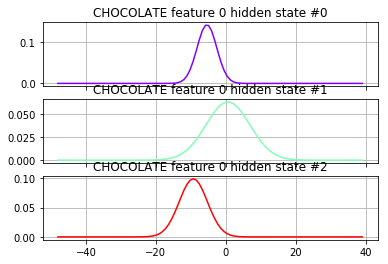

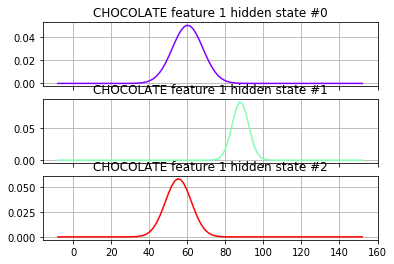

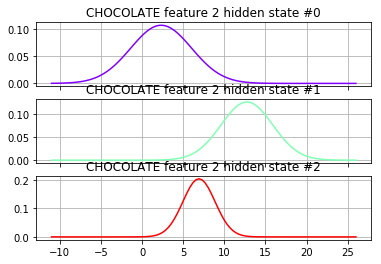

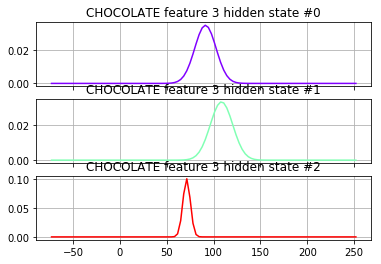

In [141]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [142]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [143]:
from sklearn.model_selection import KFold

#training = asl.build_training(features_ground) # Experiment here with different feature sets
training = asl.build_training(features_custom)
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [144]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [145]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
all_features = [features_ground,features_norm,features_delta,features_polar,features_custom,features_custom_1,features_custom_2,features_custom_3]
#training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
for feature in all_features:
    training = asl.build_training(feature)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training with {} complete for {} with {} states with time {} seconds".format(feature[0].split('-')[0], word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))


Training with grnd complete for FISH with 15 states with time 0.07552341627888381 seconds
Training with grnd complete for BOOK with 15 states with time 1.145160228596069 seconds
Training with grnd complete for VEGETABLE with 15 states with time 0.35940028028562665 seconds
Training with grnd complete for FUTURE with 15 states with time 0.9971119215479121 seconds
Training with grnd complete for JOHN with 15 states with time 11.65242303092964 seconds
Training with norm complete for FISH with 15 states with time 0.07618061220273376 seconds
Training with norm complete for BOOK with 15 states with time 0.9693407267332077 seconds
Training with norm complete for VEGETABLE with 15 states with time 0.5615478521212935 seconds
Training with norm complete for FUTURE with 15 states with time 1.0082875454099849 seconds
Training with norm complete for JOHN with 15 states with time 10.084606399177574 seconds
Training with delta complete for FISH with 15 states with time 0.07507687399629503 seconds
Trai

In [147]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

#training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
for feature in all_features:
    training = asl.build_training(feature)
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training with {} complete for {} with {} states with time {} seconds".format(feature[0].split('-')[0], word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

Training with grnd complete for FISH with 5 states with time 0.7000337191857398 seconds
Training with grnd complete for BOOK with 8 states with time 3.4247757415287197 seconds
Training with grnd complete for VEGETABLE with 9 states with time 1.280613924143836 seconds
Training with grnd complete for FUTURE with 4 states with time 3.638097108458169 seconds
Training with grnd complete for JOHN with 10 states with time 34.22522513626609 seconds
Training with norm complete for FISH with 2 states with time 0.6930247255368158 seconds
Training with norm complete for BOOK with 5 states with time 3.522535569849424 seconds
Training with norm complete for VEGETABLE with 5 states with time 1.3617708671372384 seconds
Training with norm complete for FUTURE with 7 states with time 3.8902259555179626 seconds
Training with norm complete for JOHN with 12 states with time 32.87804424017668 seconds
Training with delta complete for FISH with 4 states with time 0.6889747595414519 seconds
Training with delta 

In [148]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

for feature in all_features:
    training = asl.build_training(feature)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training with {} complete for {} with {} states with time {} seconds".format(feature[0].split('-')[0], word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

Training with grnd complete for FISH with 3 states with time 1.5593714616261423 seconds
Training with grnd complete for BOOK with 15 states with time 7.06723257934209 seconds
Training with grnd complete for VEGETABLE with 15 states with time 5.132448952994309 seconds
Training with grnd complete for FUTURE with 15 states with time 7.1944751648698 seconds
Training with grnd complete for JOHN with 15 states with time 39.388284356333315 seconds
Training with norm complete for FISH with 2 states with time 3.9756709469947964 seconds
Training with norm complete for BOOK with 15 states with time 6.673244844074361 seconds
Training with norm complete for VEGETABLE with 5 states with time 4.958219960681163 seconds
Training with norm complete for FUTURE with 15 states with time 7.264452460920438 seconds
Training with norm complete for JOHN with 15 states with time 35.408267211401835 seconds
Training with delta complete for FISH with 4 states with time 1.3277594187529758 seconds
Training with delta

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** Cross Validation is not penalizing and reward most complicated models but with advantage of completing much faster than other two model selectors. For all testing words and with any available features, This selector choose most complicated model 

DIC - Penalizes heavily in such a way that this selector choose simplest possible model most of the times but with steep price of computational time.

BIC - Is in middle path between CV and DIC. Unlike CV, BIC penalizes complex models but not as heavily as DIC penalizes. BIC do takes much longer than CV but much superior compared to DIC.

It seems BIC is choice for any generic requirements. CV and DIC seems better fit to specific needs.

NOTE: I have watched below video while trying to understand model selectors. So My response has Chris A. Mack's influence.
https://www.youtube.com/watch?v=40uFLHV5O5I&list=LL-mo5yrh10EbPK9SUzoMngg

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [149]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 57.451s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [150]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

for feature in all_features:
    models = train_all_words(feature, SelectorConstant)
    print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [151]:
test_set = asl.build_test(features_ground)
#print("Number of test set items: {}".format(test_set.num_items))
#print("Number of test set sentences: {}".format(len(test_set.sentences_index)))
#test_set.df[test_set.df['video']==7]
#X = test_set.get_item_sequences(0)
#print(X)
test_set.wordlist
# John 0, Write 1, homework 2 - video 2 has this words in this order, video 7 - 3(John),4(can),5(go),6(can)

['JOHN',
 'WRITE',
 'HOMEWORK',
 'JOHN',
 'CAN',
 'GO',
 'CAN',
 'JOHN',
 'CAN',
 'GO',
 'CAN',
 'JOHN',
 'FISH',
 'WONT',
 'EAT',
 'BUT',
 'CAN',
 'EAT',
 'CHICKEN',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'MARY',
 'VEGETABLE',
 'KNOW',
 'IX',
 'LIKE',
 'CORN1',
 'JOHN',
 'IX',
 'THINK',
 'MARY',
 'LOVE',
 'JOHN',
 'MUST',
 'BUY',
 'HOUSE',
 'FUTURE',
 'JOHN',
 'BUY',
 'CAR',
 'SHOULD',
 'JOHN',
 'SHOULD',
 'NOT',
 'BUY',
 'HOUSE',
 'JOHN',
 'DECIDE',
 'VISIT',
 'MARY',
 'JOHN',
 'FUTURE',
 'NOT',
 'BUY',
 'HOUSE',
 'JOHN',
 'WILL',
 'VISIT',
 'MARY',
 'JOHN',
 'NOT',
 'VISIT',
 'MARY',
 'ANN',
 'BLAME',
 'MARY',
 'IX-1P',
 'FIND',
 'SOMETHING-ONE',
 'BOOK',
 'JOHN',
 'IX',
 'GIVE',
 'MAN',
 'IX',
 'NEW',
 'COAT',
 'JOHN',
 'GIVE',
 'IX',
 'SOMETHING-ONE',
 'WOMAN',
 'BOOK',
 'JOHN',
 'GIVE',
 'IX',
 'SOMETHING-ONE',
 'WOMAN',
 'BOOK',
 'POSS',
 'NEW',
 'CAR',
 'BREAK-DOWN',
 'JOHN',
 'LEG',
 'JOHN',
 'POSS'

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [152]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [158]:
from my_model_selectors import SelectorCV
from my_model_selectors import SelectorDIC
from my_model_selectors import SelectorBIC
# TODO Choose a feature set and model selector
# [features_ground,features_norm,features_delta,features_polar,features_custom,features_custom_1,features_custom_2,features_custom_3]
#features = features_ground # change as needed
all_selectors = [SelectorCV, SelectorBIC, SelectorDIC]

#model_selector = SelectorBIC #SelectorDIC #SelectorConstant # change as needed
for features in all_features:
    for model_selector in all_selectors:
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        print('Model performance with features: {} and model selector: {}',features, model_selector)
        show_errors(guesses, test_set)

####################### features ground ####################### 
## SelectorConstant
# **** WER = 0.6685393258426966
# Total correct: 59 out of 178
## SelectorCV
# **** WER = 0.5898876404494382
# Total correct: 73 out of 178
## selectorBIC
# **** WER = 0.5617977528089888
# Total correct: 78 out of 178
## SelectorDIC
# **** WER = 0.6292134831460674  ## Expecting better results "Is there any issue with DIC implementation?"
# Total correct: 66 out of 178

####################### features norm #######################
## SelectorConstant
# **** WER = 0.6235955056179775
# Total correct: 67 out of 178
## SelectorCV
# **** WER = 0.6067415730337079
# Total correct: 70 out of 178
## SelectorBIC
# **** WER = 0.6404494382022472
# Total correct: 64 out of 178
## SelectorDIC
# **** WER = 0.6685393258426966
# Total correct: 59 out of 178

####################### features delta #######################
## SelectorConstant
# **** WER = 0.6292134831460674
# Total correct: 66 out of 178
## SelectorCV
# **** WER = 0.6348314606741573
# Total correct: 65 out of 178
## SelectorBIC
# **** WER = 0.6067415730337079
# Total correct: 70 out of 178
## SelectorDIC
# **** WER = 0.6348314606741573
# Total correct: 65 out of 178

####################### features Polar #######################
## SelectorConstant
# **** WER = 0.6179775280898876
# Total correct: 68 out of 178
## SelectorCV
# **** WER = 0.550561797752809
# Total correct: 80 out of 178
## SelectorBIC
# **** WER = 0.5337078651685393
# Total correct: 83 out of 178
## SelectorDIC
# **** WER = 0.6629213483146067
# Total correct: 60 out of 178

## SelectorBIC with Hyperparameter alpha = 1.5 & 1.4
#**** WER = 0.5168539325842697
#Total correct: 86 out of 178
## BIC with alpha = 0.3
# **** WER = 0.5617977528089888
# Total correct: 78 out of 178
## BIC with alpha = 1.8 & 1.2
# **** WER = 0.5393258426966292
# Total correct: 82 out of 178
## BIC with alpha = 1.6
# **** WER = 0.5393258426966292
# Total correct: 82 out of 178
## BIC with alpha = 1.489
# **** WER = 0.5112359550561798
# Total correct: 87 out of 178

## DIC with alpha = 1.4
# **** WER = 0.5393258426966292
# Total correct: 82 out of 178

## DIC with alpha = 1.8
# **** WER = 0.5393258426966292
# Total correct: 82 out of 178

## DIC alpha = 1.5,1.8,2.0,2.2,2.5,2.8,3.5,5.5 -> 82, 0.01,0.1,0.5,0.8 -> 80, 0.9,1.0 -> 81,

####################### features Custom #######################
## SelectorConstant
# **** WER = 0.5730337078651685
# Total correct: 76 out of 178
## SelectorCV
# **** WER = 0.5898876404494382
# Total correct: 73 out of 178
## SelectorBIC
# **** WER = 0.550561797752809
# Total correct: 80 out of 178
## SelectorDIC
# **** WER = 0.5955056179775281
# Total correct: 72 out of 178


Model performance with features: {} and model selector: {} ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] <class 'my_model_selectors.SelectorCV'>

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *TOY1 *WHAT                               JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *NEW-YORK *CAR *CHICAGO *MARY       JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *IX *GO *MARY *IX                               MARY VEGETABLE KNOW


   50: *JOHN *FUTURE *GIVE1 CAR *JOHN                                FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
   57: *MARY *VISIT VISIT MARY                                       JOHN DECIDE VISIT MARY
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
   71: JOHN *JOHN *NEW-YORK MARY                                     JOHN WILL VISIT MARY
   74: *IX *GO *MARY MARY                                            JOHN NOT VISIT MARY
   77: *JOHN BLAME *NEW-YORK                                         ANN BLAME MARY
   84: *NEW-YORK *NEW-YORK *VISIT BOOK                               IX-1P FIND SOMETHING-ONE BOOK
   89: *MARY IX *IX *IX IX *ARRIVE *BOOK                             JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *TOY1 IX *TOY1 *VISIT *ARRIVE                            JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX *SEARCH-FOR BOOK               

   40: *MARY *VISIT *GIVE MARY *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE                                            JOHN MUST BUY HOUSE
   50: *JOHN *SEE BUY CAR *BLAME                                     FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
   57: *MARY *MARY VISIT MARY                                        JOHN DECIDE VISIT MARY
   67: *SHOULD FUTURE *WHO BUY HOUSE                                 JOHN FUTURE NOT BUY HOUSE
   71: JOHN *FUTURE VISIT MARY                                       JOHN WILL VISIT MARY
   74: *IX *VISIT *MARY MARY                                         JOHN NOT VISIT MARY
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
   84: *JOHN *ARRIVE *HOMEWORK *COAT                                 IX-1P FIND SOMETHING-ONE BOOK
   89: *MARY *POSS *IX *IX IX *ARRIVE *BOOK                          JOHN IX G

   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE                                            JOHN MUST BUY HOUSE
   50: *JOHN *FUTURE *GIVE1 CAR *JOHN                                FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
   57: *MARY *VISIT VISIT MARY                                       JOHN DECIDE VISIT MARY
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
   71: JOHN *FINISH VISIT MARY                                       JOHN WILL VISIT MARY
   74: *IX *GO *MARY MARY                                            JO

  105: JOHN *POSS                                                    JOHN LEG
  107: *MARY POSS *BOX *MARY *TOY1                                   JOHN POSS FRIEND HAVE CANDY
  108: *LOVE *JOHN                                                   WOMAN ARRIVE
  113: *SHOULD CAR *IX *JOHN *BOX                                    IX CAR BLUE SUE BUY
  119: *SELF *BUY1 IX *JOHN *GO                                      SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 *CAR *JOHN BOOK                                    JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE JOHN WHO                                                 LOVE JOHN WHO
  167: JOHN IX *MARY LOVE *IX                                        JOHN IX SAY LOVE MARY
  171: *LIKE *TOY1 BLAME                                             JOHN MARY BLAME
  174: *CAR *GIVE1 GIVE1 *


  113: IX CAR *IX SUE *HAVE                                          IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 IX *JOHN *FINISH                                SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 *HOUSE YESTERDAY BOOK                              JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *IX WHO                                                  LOVE JOHN WHO
  167: *MARY IX *MARY LOVE *IX                                       JOHN IX SAY LOVE MARY
  171: *MARY *IX BLAME                                               JOHN MARY BLAME
  174: *NEW *GIVE1 GIVE1 *VISIT TOY                                  PEOPLE GROUP GIVE1 JANA TOY
  181: *BLAME *BOX                                                   JOHN ARRIVE
  184: *IX *YESTERDAY *GIVE1 TEACHER APPLE                           ALL BOY GIVE TEACHER APPLE
  189: *


  107: *MARY POSS *BOX *MARY *TOY1                                   JOHN POSS FRIEND HAVE CANDY
  108: *LOVE *JOHN                                                   WOMAN ARRIVE
  113: *SHOULD CAR *IX *JOHN *BOX                                    IX CAR BLUE SUE BUY
  119: SUE *BUY1 IX *JOHN *GO                                        SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 *CAR *JOHN BOOK                                    JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE JOHN WHO                                                 LOVE JOHN WHO
  167: JOHN IX *MARY LOVE *IX                                        JOHN IX SAY LOVE MARY
  171: *MARY *JOHN BLAME                                             JOHN MARY BLAME
  174: *CAR *GIVE1 GIVE1 *YESTERDAY *CAR                             PEOPLE GROUP GIVE1 JANA TOY
  181:


  105: JOHN *MARY                                                    JOHN LEG
  107: JOHN *IX *VISIT *JOHN *MARY                                   JOHN POSS FRIEND HAVE CANDY
  108: *IX *BOOK                                                     WOMAN ARRIVE
  113: *JOHN CAR *MARY *IX *GIVE1                                    IX CAR BLUE SUE BUY
  119: *JOHN *GIVE1 IX CAR *MARY                                     SUE BUY IX CAR BLUE
  122: JOHN *HAVE *MARY                                              JOHN READ BOOK
  139: JOHN *NEW WHAT *LOVE *CAR                                     JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY *JOHN WHAT *MARY                                     JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *MARY *JOHN                                              LOVE JOHN WHO
  167: JOHN IX *IX *ARRIVE MARY                                      JOHN IX SAY LOVE MARY
  171: JOHN MARY BLAME                                               JOHN MARY BLAME
  174: *ARRIVE *JOHN GIVE

   74: JOHN *IX *IX MARY                                             JOHN NOT VISIT MARY
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
   84: *JOHN *NEW *IX *MARY                                          IX-1P FIND SOMETHING-ONE BOOK
   89: *GIVE1 *JOHN GIVE *IX IX NEW *CAN                             JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *JOHN *JOHN *IX WOMAN *JOHN                              JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX *JOHN *JOHN *VISIT *ARRIVE                           JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *JOHN NEW CAR BREAK-DOWN                                      POSS NEW CAR BREAK-DOWN
  105: JOHN *JOHN                                                    JOHN LEG
  107: JOHN *GIVE1 FRIEND HAVE *MARY                                 JOHN POSS FRIEND HAVE CANDY
  108: *IX ARRIVE                                                    WOMAN ARRIVE
  113: *JOHN CAR *MARY *JOHN *BUY1                                

    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *FUTURE CAN                                         JOHN CAN GO CAN
   21: *MARY *MARY *GIVE1 *MARY *WHAT *IX *MARY *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WOMAN *MARY *JOHN IX                                    JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX *WOMAN                                       JOHN LIKE IX IX IX
   30: JOHN *MARY *SOMETHING-ONE IX IX                               JOHN LIKE IX IX IX
   36: *JOHN *JOHN *IX *NEW-YORK *VISIT *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *CAR HOUSE                                           JOHN MUST BUY HOUSE
   50: *JOHN *MARY BUY CAR *MARY                                     FUTURE JOHN BUY CAR SHOULD
   54: JOHN *JOHN *JOHN BUY HOUSE                                    JOHN SHO


  113: IX CAR *IX *MARY *JOHN                                        IX CAR BLUE SUE BUY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *ARRIVE WHAT *MARY *ARRIVE                               JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE JOHN WHO                                                 LOVE JOHN WHO
  167: JOHN *MARY *VISIT LOVE MARY                                   JOHN IX SAY LOVE MARY
  171: *IX MARY BLAME                                                JOHN MARY BLAME
  174: *JOHN *JOHN GIVE1 *YESTERDAY *JOHN                            PEOPLE GROUP GIVE1 JANA TOY
  181: *YESTERDAY ARRIVE                                             JOHN ARRIVE
  184: *GO *IX *GIVE1 TEACHER *YESTERDAY                             ALL BOY GIVE TEACHER APPLE
  189: *


   84: *HOMEWORK *STUDENT *HOMEWORK *COAT                            IX-1P FIND SOMETHING-ONE BOOK
   89: *GIVE *GIVE GIVE *IX IX *BUY *BOOK                            JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *HAVE IX SOMETHING-ONE WOMAN *COAT                       JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN GIVE IX *WOMAN WOMAN BOOK                                JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *VEGETABLE                                               JOHN LEG
  107: JOHN *IX *HAVE *GO *JANA                                      JOHN POSS FRIEND HAVE CANDY
  108: WOMAN *BOOK                                                   WOMAN ARRIVE
  113: IX CAR *IX *IX *BOX                                           IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 *CAR CAR *GO                                    SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                     


   43: JOHN *IX BUY HOUSE                                            JOHN MUST BUY HOUSE
   50: *JOHN *SEE BUY CAR *JOHN                                      FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
   57: *MARY *GO *GO MARY                                            JOHN DECIDE VISIT MARY
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
   71: JOHN *FUTURE *GIVE1 MARY                                      JOHN WILL VISIT MARY
   74: *IX *GO *GO *VISIT                                            JOHN NOT VISIT MARY
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
   84: *HOMEWORK *GIVE1 *GIVE1 *COAT                                 IX-1P FIND SOMETHING-ONE BOOK
   89: *GIVE *GIVE *WOMAN *WOMAN IX *ARRIVE *BOOK                    JOHN IX GIVE MAN IX NEW COAT
   90: JOHN GIVE IX SOMETHING-ONE WOMAN *ARRIVE                      JOH


   43: JOHN *TOMORROW *IX HOUSE                                      JOHN MUST BUY HOUSE
   50: *JOHN *SHOULD BUY CAR *MARY                                   FUTURE JOHN BUY CAR SHOULD
   54: JOHN *IX *JOHN BUY HOUSE                                      JOHN SHOULD NOT BUY HOUSE
   57: JOHN *JOHN *IX *IX                                            JOHN DECIDE VISIT MARY
   67: JOHN *IX *SAY *WOMAN HOUSE                                    JOHN FUTURE NOT BUY HOUSE
   71: JOHN *TOY1 VISIT *CAR                                         JOHN WILL VISIT MARY
   74: JOHN *IX *GIVE MARY                                           JOHN NOT VISIT MARY
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
   84: *JOHN *CAR *IX *VIDEOTAPE                                     IX-1P FIND SOMETHING-ONE BOOK
   89: JOHN IX *IX *IX *GIVE1 *CAR *CAN                              JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *PAST IX *IX WOMAN BOOK                                  JOH


   25: JOHN *WOMAN IX *JOHN IX                                       JOHN LIKE IX IX IX
   28: JOHN *IX *MARY IX *LIKE                                       JOHN LIKE IX IX IX
   30: JOHN *CORN *SEARCH-FOR IX *LIKE                               JOHN LIKE IX IX IX
   36: *JOHN *VIDEOTAPE KNOW *GIVE2 *HERE *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: *CHINA IX *JOHN *CORN1 *APPLE                                 JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD *FINISH HOUSE                                    JOHN MUST BUY HOUSE
   50: *JOHN *VEGETABLE BUY CAR *MARY                                FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD *JOHN BUY HOUSE                                   JOHN SHOULD NOT BUY HOUSE
   57: JOHN *JOHN *IX *SHOULD                                        JOHN DECIDE VISIT MARY
   67: JOHN *JOHN *POTATO BUY HOUSE                                  JOHN FUTURE NOT BUY HOUSE
   71: JOHN *SUE VISIT *CAR                                          JOH


  158: LOVE *WHO *MARY                                               LOVE JOHN WHO
  167: *MARY *SHOULD *IX LOVE *IX                                    JOHN IX SAY LOVE MARY
  171: JOHN *JOHN BLAME                                              JOHN MARY BLAME
  174: *JOHN *JOHN GIVE1 *MARY *CAR                                  PEOPLE GROUP GIVE1 JANA TOY
  181: JOHN ARRIVE                                                   JOHN ARRIVE
  184: ALL *JOHN *GIVE1 TEACHER *MARY                                ALL BOY GIVE TEACHER APPLE
  189: JOHN *IX *GIVE1 *ARRIVE                                       JOHN GIVE GIRL BOX
  193: JOHN *IX GIRL BOX                                             JOHN GIVE GIRL BOX
  199: *JOHN *ARRIVE *MARY                                           LIKE CHOCOLATE WHO
  201: JOHN *MARY *IX *IX BUY HOUSE                                  JOHN TELL MARY IX-1P BUY HOUSE
Model performance with features: {} and model selector: {} ['rescale_grnd-rx', 'rescale_grnd-ry', 'res


   92: JOHN *IX IX *IX *IX BOOK                                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *IX NEW CAR *ARRIVE                                           POSS NEW CAR BREAK-DOWN
  105: JOHN *FRANK                                                   JOHN LEG
  107: JOHN *IX *HAVE *ARRIVE *JOHN                                  JOHN POSS FRIEND HAVE CANDY
  108: *IX ARRIVE                                                    WOMAN ARRIVE
  113: IX CAR *IX *MARY *BOX                                         IX CAR BLUE SUE BUY
  119: *VISIT *BUY1 IX *BOX *IX                                      SUE BUY IX CAR BLUE
  122: JOHN *BUY BOOK                                                JOHN READ BOOK
  139: JOHN *BUY1 WHAT *MARY *ARRIVE                                 JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE JOHN WHO                                                 LOVE JOHN WHO
 

   21: JOHN *HOMEWORK *JOHN *MARY *CAR *CAR *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE *LOVE                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *IX *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *GIVE MARY *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE                                            JOHN MUST BUY HOUSE
   50: *JOHN *SEE BUY CAR *BLAME                                     FUTURE JOHN BUY CAR SHOULD
   54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
   57: *MARY *MARY VISIT MARY                                        JOHN DECIDE VISIT MARY
   67: *SHOULD FUTURE *WHO BUY HOUSE                        


   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
   84: *JOHN *GIVE1 *VISIT BOOK                                      IX-1P FIND SOMETHING-ONE BOOK
   89: *MARY IX *IX *IX IX *ARRIVE *BOOK                             JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *SOMETHING-ONE IX *IX *VISIT *ARRIVE                     JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX *IX BOOK                                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *IX NEW CAR *ARRIVE                                           POSS NEW CAR BREAK-DOWN
  105: JOHN *FRANK                                                   JOHN LEG
  107: JOHN *IX *HAVE *ARRIVE *JOHN                                  JOHN POSS FRIEND HAVE CANDY
  108: *IX ARRIVE                                                    WOMAN ARRIVE
  113: IX CAR *IX *MARY *BOX                                         IX CAR BLUE SUE BUY
  119: *VISIT *BUY1 IX *BOX *IX                                  

  113: *JOHN CAR *CAR *LEAVE *CAR                                    IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 IX CAR *GIVE                                    SUE BUY IX CAR BLUE
  122: JOHN *BOX BOOK                                                JOHN READ BOOK
  139: JOHN *ARRIVE *HOUSE *HOUSE *CHOCOLATE                         JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN *SOMETHING-ONE YESTERDAY *HOUSE BOOK                     JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *MARY WHO                                                LOVE JOHN WHO
  167: JOHN IX *IX LOVE *LOVE                                        JOHN IX SAY LOVE MARY
  171: JOHN MARY BLAME                                               JOHN MARY BLAME
  174: *CAR *GIVE3 GIVE1 *GIRL *CAR                                  PEOPLE GROUP GIVE1 JANA TOY
  181: *HOUSE ARRIVE                                                 JOHN ARRIVE
  184: *IX BOY *GIVE1 TEACHER APPLE                                  ALL BOY GIVE TEACHER APPLE
  189: *T

   57: *MARY *VISIT *GIVE *GIVE2                                     JOHN DECIDE VISIT MARY
   67: *IX FUTURE *WOMAN BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
   71: JOHN WILL *GIVE1 MARY                                         JOHN WILL VISIT MARY
   74: *IX *IX *TELL *VISIT                                          JOHN NOT VISIT MARY
   77: *JOHN BLAME *BLAME                                            ANN BLAME MARY
   84: *JOHN *BUY *FUTURE BOOK                                       IX-1P FIND SOMETHING-ONE BOOK
   89: JOHN *GIVE *IX *GO IX *BOOK COAT                              JOHN IX GIVE MAN IX NEW COAT
   90: *TOY1 *FUTURE IX *IX *NOT BOOK                                JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX WOMAN BOOK                                    JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *SEE                              


  108: *JOHN *LOVE                                                   WOMAN ARRIVE
  113: *JOHN *BLAME *CAR *MARY *ARRIVE                               IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 IX CAR *GO                                      SUE BUY IX CAR BLUE
  122: JOHN *BOX BOOK                                                JOHN READ BOOK
  139: JOHN *ARRIVE *HOUSE *HOUSE BOOK                               JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN *SOMETHING-ONE *ARRIVE *HOUSE BOOK                       JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *MARY WHO                                                LOVE JOHN WHO
  167: JOHN IX *VEGETABLE LOVE *LOVE                                 JOHN IX SAY LOVE MARY
  171: JOHN MARY BLAME                                               JOHN MARY BLAME
  174: *CAR *BOX GIVE1 *CAR *CAR                                     PEOPLE GROUP GIVE1 JANA TOY
  181: *HOUSE ARRIVE                                                 JOHN ARRIVE
  184: *IX BOY *GIVE1 


   25: JOHN LIKE *HOUSE *WHO *CAR                                    JOHN LIKE IX IX IX
   28: JOHN LIKE *WHAT *WHAT *CAN                                    JOHN LIKE IX IX IX
   30: JOHN *SEE *PREFER *FUTURE *BLAME                              JOHN LIKE IX IX IX
   36: *FUTURE *PREFER *IX *GO *FRANK *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *PREFER *SHOULD *SEE                                  JOHN IX THINK MARY LOVE
   43: JOHN *BOX BUY HOUSE                                           JOHN MUST BUY HOUSE
   50: *VISIT *SEE BUY *HOUSE *GO                                    FUTURE JOHN BUY CAR SHOULD
   54: JOHN *SOMETHING-ONE *WOMAN BUY HOUSE                          JOHN SHOULD NOT BUY HOUSE
   57: JOHN *IX *WOMAN *IX                                           JOHN DECIDE VISIT MARY
   67: *HOUSE *JOHN *LIKE *BUY1 HOUSE                                JOHN FUTURE NOT BUY HOUSE
   71: JOHN *WHAT *CAR *HOUSE                                        JOH


   50: *PREFER *PREFER BUY *TOMORROW *MOTHER                         FUTURE JOHN BUY CAR SHOULD
   54: JOHN *YESTERDAY *MARY BUY HOUSE                               JOHN SHOULD NOT BUY HOUSE
   57: JOHN *IX *SUE *SOMETHING-ONE                                  JOHN DECIDE VISIT MARY
   67: *TOMORROW *JOHN *BROCCOLI *COAT HOUSE                         JOHN FUTURE NOT BUY HOUSE
   71: JOHN *KNOW *BOX *WHAT                                         JOHN WILL VISIT MARY
   74: JOHN *JANA *LEAVE *SOMETHING-ONE                              JOHN NOT VISIT MARY
   77: *HOUSE *BUY1 *BUT                                             ANN BLAME MARY
   84: *LAST-WEEK *HERE *CAN BOOK                                    IX-1P FIND SOMETHING-ONE BOOK
   89: JOHN *TOY1 *BILL *JOHN IX *VIDEOTAPE COAT                     JOHN IX GIVE MAN IX NEW COAT
   90: *SEARCH-FOR *IX IX *GIVE3 *MAN *NEW-YORK                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN GIVE IX *GIRL *BROTHER BOOK               

In [159]:
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5112359550561798
Total correct: 87 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE HOMEWORK                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *FUTURE *CAR *CAR *FUTURE *WHO            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [160]:
features = features_custom_1 # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5168539325842697
Total correct: 86 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *GO1 GO *WHAT                                            JOHN CAN GO CAN
   12: *IX *WHAT *CAN CAN                                            JOHN CAN GO CAN
   21: JOHN *HOMEWORK *JOHN *MARY *CAR *CAR *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE *LOVE                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *IX *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *GIVE MARY *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [161]:
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** 
    SelectorBIC and Polar: 0.51 (WER)
    SelectorBIC and Custom_1(Rescale Cartesian): 0.52 (WER)
    SelectorBIC and Polar: 0.54 (WER)
    
    BIC and Polar is the best combination as word error rate is lowest and also BIC does discriminate complexity but doesn't discriminate too heavily. In that process it allows models to be complicated when needed and models when needed as well.
    
    As mentioned in introduction of Part 4, It is really hard(if not impossible) to get best results in this way.
    Similar the way how human brain works, we should take over all context into the consideration. Instead of giving 100% weight to probability to possible word, If we distribute weights between word and context we will get much better results.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [162]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 58.842s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [56]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-5181.615687,-3.698140e+05,-4246.728284,-451.752589,-11006.346717,-330.252955,-57361.034195,-1059.646490,-6232.402381,-730.840071,...,-3819.797911,-382.341772,-5.483855e+05,-414.194269,-368.770642,-7592.959725,-1510.376536,-2601.350158,-1880.946116,-381.335786
1,-9616.691817,-3.904833e+05,-61294.355912,-237.389808,-20807.709374,-622.548090,-69556.976370,-231.625961,-4528.093860,-691.791172,...,-599.508595,-539.365476,-6.956279e+05,-435.433778,-473.880700,-10987.184078,-571.831222,-734.529603,-242.407341,-848.454162
2,-15246.719708,-1.569626e+06,-78812.759254,-488.327678,-33364.915965,-1010.463343,-119359.526616,-946.857128,-4068.373674,-1366.420741,...,-1918.019292,-889.291553,-1.362076e+06,-948.660941,-1849.676559,-17612.725279,-2311.545056,-2983.280796,-1588.027904,-1068.472664
3,-1598.187828,-2.929867e+06,-2990.039604,-408.974438,-969.493693,-833.917564,-23600.137557,-1072.555272,-54108.019784,-879.292982,...,-4341.903965,-345.167442,-1.517667e+06,-757.470732,-889.513918,-23860.442735,-578.375249,-1937.438257,-13632.014369,-837.646100
4,-4305.851220,-1.342958e+06,-5051.642751,-124.057682,-3534.971639,-148.353789,-7485.767877,-177.584018,-2208.462718,-114.360780,...,-580.381411,-113.120548,-3.679653e+05,-116.768502,-627.006558,-11006.633435,-226.317873,-3257.931485,-4618.571140,-295.799131
